# Processing PyTOAST simulated L1B files using OBPG's OCSSW tools

This notebook demonstrates how to use NASA Ocean Biology Processing Group's (OBGP) Ocean Color Science Software (OCSSW) libraries using the command line interface in a Jupyter Notebook. It is modeled off of a [PACE Hackweek tutorial](https://pacehackweek.github.io/pace-2024/presentations/hackweek/ocssw_processing.html). Please refer to the [Installing the SeaDAS Command Line Tools (OCSSW) tutorial](https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/) listed under 'PACE Mission Basics' to learn how to install the OCSSW tools. 

This notebook runs the processing code of l2gen, l2bin, l3bin, and l3mapgen on **one** PyTOAST simulated L1B file. The parameters used in this notebook are the exact parameters that were used to process the entire L1B dataset; however, they can be changed depending on user needs.

The goal of this notebook is to demonstrate the functionalities of the OCSSW tools, providing users with code to process the PyTOAST simulated L1B files however they wish. We include example code at the bottom of the notebook to batch process all L1B data. 

In [3]:
import csv
import os
import glob
import xarray as xr
from xarray.backends.api import open_datatree


In [4]:
os.environ.setdefault("OCSSWROOT", "/accounts/awindled/ocssw/")

'/accounts/awindled/ocssw/'

# 1. Define function to write OCSSW parameters files

In [5]:
def write_par(path, par):
    """
    Prepare a "par file" to be read by one of the OCSSW tools, as an
    alternative to specifying each parameter on the command line.

    Args:
        path (str): where to write the parameter file
        par (dict): the parameter names and values included in the file
    """
    with open(path, "w") as file:
        writer = csv.writer(file, delimiter="=")
        values = writer.writerows(par.items())

# 2. Import PyTOAST simulated L1B files

Level-1B files can be downloaded at (zenodo url). We will load one file into the notebook:

In [6]:
l1b_file = '/glusteruser/awindled/PyTOAST/L1B/PACE_OCI_SIM.20220315T112333.L1B.V12.nc'
l1b_file

'/glusteruser/awindled/PyTOAST/L1B/PACE_OCI_SIM.20220315T112333.L1B.V12.nc'

The Level-1B files contain top-of-atmosphere reflectances, typically denoted as __. On OCI, the reflectances are grouped into blue, red, and short-wave infrared (SWIR) wavelengths. Open the dataset’s “observation_data” group in the netCDF file using xarray to plot a “rhot_red” wavelength.

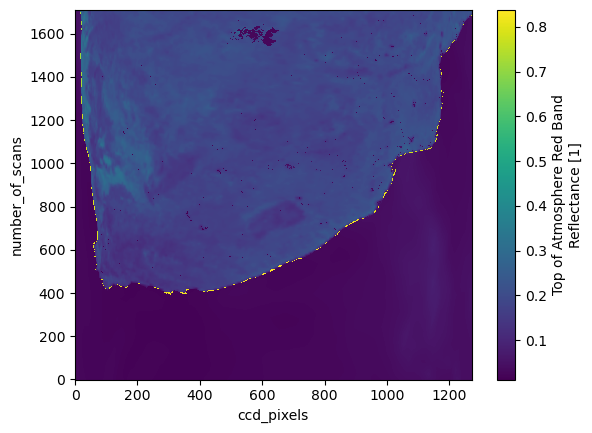

In [7]:
dataset = xr.open_dataset(l1b_file, group="observation_data")
artist = dataset["rhot_red"].sel({"red_bands": 100}).plot()

# 3. Process L1B data with l2gen

L2gen creates a Level-2 file from an input Level-1B file. It can produce hundreds of geophysical data products and can be configured in thousands of different combinations. 

Let's run the l2gen command with the single argument help to view the extensive list of options available. 

In [8]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2gen help

msl12 9.7.0-V2024.3 (Sep  5 2024 17:41:39)
Usage: msl12 argument-list

  The argument-list is a set of keyword=value pairs. The arguments can
  be specified on the commandline, or put into a parameter file, or the
  two methods can be used together, with commandline over-riding.

  return value: 0=OK, 1=error, 110=north,south,east,west does not intersect
  file data.

The list of valid keywords follows:

   help (boolean) (alias=h) (default=false) = print usage information
   version (boolean) (default=false) = print the version
        information
   dump_options (boolean) (default=false) = print
        information about each option
   dump_options_paramfile (ofile) = print
        information about each option to paramfile
   dump_options_xmlfile (ofile) = print
        information about each option to XML file
   par (ifile) = input parameter file
   pversion (string) (default=Unspecified) = processing version string
   suite (string) (default=OC) = product suite string for loading

We run l2gen using the following parameters:
* A list of individual products that we want in the final L3 file
* Masking high Lt (maskhilt=0)
* No masking of clouds (maskcloud=off)

TODO: Ask Sean if maskhilt=0 is the same as the default=on?

In [11]:
par = {
    "ifile": l1b_file,
    "ofile": str(l1b_file).replace(".L1B.", ".L2."),
    "l2prod": "Rrs,chlor_a,a_413,a_442,a_490, a_510, a_555, a_670, bb_442,aph_442,Kd_442,adg_442,adg_s,bbp_442,bbp_s,angstrom,aot_865",
    "maskhilt": 0,
    "maskcloud": "off"
}
write_par("l2gen.par", par)


#412, 443, 490, 510, 555, 670

In [12]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2gen par=l2gen.par

Loading default parameters from /accounts/awindled/ocssw//share/common/msl12_defaults.par
Input file /glusteruser/awindled/PyTOAST/L1B/PACE_OCI_SIM.20220315T112333.L1B.V12.nc is PACE L1B file.

Loading characteristics for OCI
Opening sensor information file /accounts/awindled/ocssw//share/oci/msl12_sensor_info.dat
  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw
    0  314.550  112.026 4.873e-01 4.208e-01 3.281e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03
    1  316.239   92.478 6.485e-01 5.806e-01 2.961e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03
    2  318.262   85.195 7.410e-01 5.473e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03
    3  320.303   82.175 7.809e-01 4.609e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03
    4  322.433   80.733 7.906e-01 3.543e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03
    5  324.649   86.251 7.915e-01 2.567e-01 3.018e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03
    6  326.828   95.932 7.891e-01 1.

In [14]:
#l2_file = open_datatree('/glusteruser/awindled/PyTOAST/L2/PACE_OCI_SIM.20220315T112333.L2.V12_5.nc')
l2_file = open_datatree('/glusteruser/awindled/PyTOAST/L1B/PACE_OCI_SIM.20220315T112333.L2.V12.nc')


l2_file = xr.merge(l2_file.to_dict().values())
l2_file = l2_file.set_coords(("longitude", "latitude"))

l2_file

<xarray.Dataset> Size: 2GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 184, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 339.0 341.0 344.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/41)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    bbp_442        (number_of_lines, pixels_per_line) float32 9MB ...
    bbp_s          (number_of_lines, pixels_per_line) float32 9MB ...
    angstrom       (number_of_lines, pixels_per_line) float32 9MB ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                          OCI Level-2 Data OC
    product_name:                   PACE_OCI_SIM.20220315T112333.L2.V12.nc
    processing_version:             Unspecified
    history:                        l2gen par=l2gen.par
    instrument:                     OCI
    platform:                       PACE
    ...                             ...
    geospatial_lon_max:             45.128036
    geospatial_lon_min:             13.119587
    startDirection:                 Ascending
    endDirection:                   Ascending
    day_night_flag:                 Day
    earth_sun_distance_correction:  1.011174201965332

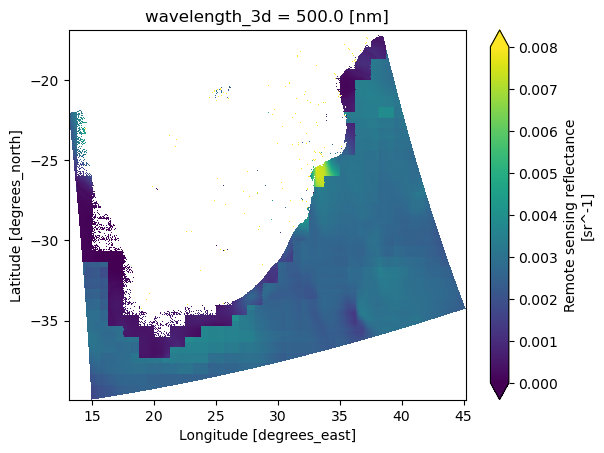

In [30]:
Rrs = l2_file["Rrs"].sel({"wavelength_3d": 500})
plot = Rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0, vmax=0.008)

# 4. Process L2 data with l2bin

In [19]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2bin help

l2bin 7.0.7 (Sep  5 2024 17:41:39)
7.0.7
Usage: l2bin argument-list

  The argument-list is a set of keyword=value pairs. The arguments can
  be specified on the commandline, or put into a parameter file, or the
  two methods can be used together, with commandline over-riding.

  return value: 0=OK, 1=error, 110=north,south,east,west does not intersect
  file data.

The list of valid keywords follows:

   help (boolean) (alias=h) (default=false) = print usage information
   version (boolean) (default=false) = print the version
        information
   dump_options (boolean) (default=false) = print
        information about each option
   dump_options_paramfile (ofile) = print
        information about each option to paramfile
   dump_options_xmlfile (ofile) = print
        information about each option to XML file
   par (ifile) (alias=parfile) = input parameter file
   ifile (ifile) (alias=infile) = input L2 file name
   ofile (ofile) (default=output) = output file name
   fileuse (ofil

In [34]:
l2_file = '/glusteruser/awindled/PyTOAST/ocssw_data/PACE_OCI_SIM.20220315T112333.L2.V12.nc'

par = {
    "ifile": l2_file,
    "ofile": str(l2_file).replace(".L2.", ".L3b."),
    "flaguse": "HIGLINT,LAND"
}
write_par("l2bin.par", par)

In [35]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2bin par=l2bin.par

l2bin 7.0.7 (Sep  5 2024 17:41:39)
Loading default parameters from /accounts/awindled/ocssw//share/common/l2bin_defaults.par
Loading default parameters from /accounts/awindled/ocssw//share/oci/l2bin_defaults.par
Loading command line parameters

1 input files
Resolution: 4
Max Qual Allowed: 255
total number of bins: 23761676
krow:     0 out of   4320  (-90.00 to -78.75) Mon Oct 14 17:54:46 2024
krow:   270 out of   4320  (-78.75 to -67.50) Mon Oct 14 17:54:46 2024
krow:   540 out of   4320  (-67.50 to -56.25) Mon Oct 14 17:54:46 2024
krow:   810 out of   4320  (-56.25 to -45.00) Mon Oct 14 17:54:46 2024
krow:  1080 out of   4320  (-45.00 to -33.75) Mon Oct 14 17:54:46 2024
# bins in row group : 1800386
# filled bins       :   50017
krow:  1350 out of   4320  (-33.75 to -22.50) Mon Oct 14 17:56:40 2024
# bins in row group : 2054034
# filled bins       :   65234
krow:  1620 out of   4320  (-22.50 to -11.25) Mon Oct 14 17:58:33 2024
# bins in row group : 2228765
# filled bins       :    90

# 5. Process L3b data with l3bin

In [36]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l3bin help

L3BIN 5.14 (Sep  5 2024 17:41:22)
5.14
l3bin ifile=input-file ofile=output-file prod=prodlist

  The input file is a list of L3 binned files.
  The argument-list is a set of keyword=value pairs. The arguments can
  be specified on the commandline, or put into a parameter file, or the
  two methods can be used together, with commandline over-riding.

  return value: 0=OK, 1=error, 110=no pixels binned. 

The list of valid keywords follows:

   help (boolean) (alias=h) (default=false) = print usage information
   version (boolean) (default=false) = print the version
        information
   verbose (boolean) (default=off) = Allow more verbose screen messages
   dump_options (boolean) (default=false) = print
        information about each option
   dump_options_paramfile (ofile) = print
        information about each option to paramfile
   dump_options_xmlfile (ofile) = print
        information about each option to XML file
   par (ifile) (alias=parfile) = input parameter file
   pversion 

# Process L3b data with l3mapgen

In [37]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l3mapgen help

l3mapgen 2.4.0-V2024.3 (Sep  5 2024 17:41:09)
Usage: l3mapgen argument-list

  This program takes a product (or products if netCDF output) from an L3 bin
  or SMI file, reprojects the data using proj.4 and writes a mapped file in
  the requested output format.

  Return values
    0 = All Good
    1 = Error
    110 = No valid data to map

  The argument list is a set of keyword=value pairs.  Arguments can
  be specified on the command line, or put into a parameter file, or the
  two methods can be used together, with command line overriding.

The list of valid keywords follows:

   help (boolean) (alias=h) (default=false) = print usage information
   version (boolean) (default=false) = print the version
        information
   dump_options (boolean) (default=false) = print
        information about each option
   dump_options_paramfile (ofile) = print
        information about each option to paramfile
   dump_options_xmlfile (ofile) = print
        information about each option to XML f

In [40]:
l3b_file = '/glusteruser/awindled/PyTOAST/ocssw_data/PACE_OCI_SIM.20220315T112333.L3b.V12.nc'

par = {
    "ifile": l3b_file,
    "ofile": str(l3b_file).replace(".L3b.", ".L3m."),
    "projection": "smi",
    "product": "Rrs,chlor_a,a_442,bb_442,aph_442,Kd_442,adg_442,adg_s,bbp_442,bbp_s,angstrom,aot_865",
    "mask_land": "yes"
}
write_par("l3mapgen.par", par)

In [41]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l3mapgen par=l3mapgen.par

Loading default parameters from /accounts/awindled/ocssw//share/oci/l3mapgen_defaults.par
l3mapgen 2.4.0-V2024.3 (Sep  5 2024 17:41:09)
ifile      : /glusteruser/awindled/PyTOAST/ocssw_data/PACE_OCI_SIM.20220315T112333.L3b.V12.nc
ofile      : /glusteruser/awindled/PyTOAST/ocssw_data/PACE_OCI_SIM.20220315T112333.L3m.V12.nc
oformat    : netcdf4
projection : smi
resolution : 4638.312m
product    : Rrs,chlor_a,a_442,bb_442,aph_442,Kd_442,adg_442,adg_s,bbp_442,bbp_s,angstrom,aot_865
north      :   90.000
south      :  -90.000
east       :  180.000
west       : -180.000
image size : 4320 x 8640

99% complete

actual data min       : -0.500000
actual data max       : 17.422007
num filled pixels     : 146373
percent filled pixels : 0.39%



In [44]:
L3m = xr.open_dataset('/glusteruser/awindled/PyTOAST/ocssw_data/PACE_OCI_SIM.20220315T112333.L3m.V12.nc')
L3m

<xarray.Dataset> Size: 29GB
Dimensions:     (wavelength: 184, lat: 4320, lon: 8640, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables: (12/13)
    Rrs         (lat, lon, wavelength) float32 27GB ...
    chlor_a     (lat, lon) float32 149MB ...
    a_442       (lat, lon) float32 149MB ...
    bb_442      (lat, lon) float32 149MB ...
    aph_442     (lat, lon) float32 149MB ...
    Kd_442      (lat, lon) float32 149MB ...
    ...          ...
    adg_s       (lat, lon) float32 149MB ...
    bbp_442     (lat, lon) float32 149MB ...
    bbp_s       (lat, lon) float32 149MB ...
    angstrom    (lat, lon) float32 149MB ...
    aot_865     (lat, lon) float32 149MB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/60)
    product_name:                     PACE_OCI_SIM.20220315T112333.L3m.V12.nc
    instrument:                       OCI
    title:                            OCI Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         PACE
    source:                           satellite observations from OCI-PACE
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        146373
    data_minimum:                     -0.5
    data_maximum:                     17.422007

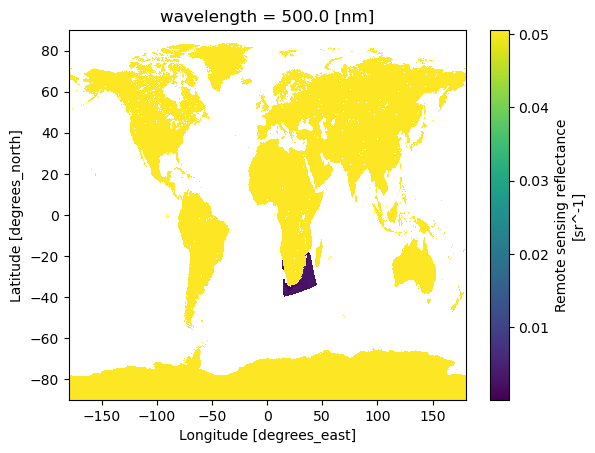

In [45]:
L3m_rrs = L3m["Rrs"].sel({"wavelength": 500})
L3m_rrs.plot()

# X. Batch processing OCSSW tools

l2gen -> l2bin -> l3bin -> l3mapgen

TODO: explain why l3bin is helpful with a lot of files

In [65]:
l1b_files = glob.glob('/glusteruser/awindled/PyTOAST/L1B/*.nc')
l1b_files

['/glusteruser/awindled/PyTOAST/L1B/PACE_OCI_SIM.20220315T132157.L1B.V12.nc',
 '/glusteruser/awindled/PyTOAST/L1B/PACE_OCI_SIM.20220315T112333.L1B.V12.nc']

TODO: figure out how to do a for loop with %%bash

In [67]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

for i in l1b_files;
do
    l2gen_par = {
        "ifile": i,
        "ofile": str(l1b_file).replace(".L1B.", ".L2."),
        "l2prod": "Rrs,chlor_a,a_442,bb_442,aph_442,Kd_442,adg_442,adg_s,bbp_442,bbp_s,angstrom,aot_865",
        "maskhilt": 0,
        "maskcloud": "off"
    }
    write_par("l2gen.par", par)
    l2gen par=l2gen.par
done


bash: line 7: syntax error near unexpected token `('
bash: line 7: `        "ofile": str(l1b_file).replace(".L1B.", ".L2."),'


CalledProcessError: Command 'b'source $OCSSWROOT/OCSSW_bash.env\n\nfor i in l1b_files;\ndo\n    l2gen_par = {\n        "ifile": i,\n        "ofile": str(l1b_file).replace(".L1B.", ".L2."),\n        "l2prod": "Rrs,chlor_a,a_442,bb_442,aph_442,Kd_442,adg_442,adg_s,bbp_442,bbp_s,angstrom,aot_865",\n        "maskhilt": 0,\n        "maskcloud": "off"\n    }\n    write_par("l2gen.par", par)\n    l2gen par=l2gen.par\ndone\n'' returned non-zero exit status 2.